<div align="center"> <h3><font color='cyan'>CSE 368: Introduction to Artificial Intelligence, FALL 2022 </font>
<h1> Uniformed and Informed Search

<h3>Checkpoint: September 29, Thu, 11:59pm
<h2><font color='red'>Final Due Date: </font> October 13, Thu, 11:59pm </div>


In [ ]:
''' 1. Install and import matplotlib library
'''

# BEGIN_YOUR_CODE
import numpy as np
import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import copy
from collections import deque
# END_YOUR_CODE

## 1. Problem Environment Definition

In [ ]:
'''
Nils Napp
Sliding Problem for AI-Class
'''

import random

class State:
    """ State of sliding number puzzle
        Contains array of values called 'board' to indicate
        tile positions, and the position of tile '0', which
        indicates the empty space on the board.         """

    boardSize = 3

    def __init__(self, s = None):

        if s == None:

            # tiles is an iterator holding numbers 0 to 9
            tiles = range(self.boardSize * self.boardSize).__iter__()

            # below line reads numbers 0-8 stored in tiles and store them in 2d array (list of lists)
            self.board = [[next(tiles) for i in range(self.boardSize)] for j in range(self.boardSize)]

            #keep track of empty position
            self.position = [0,0]

        else:
            #copy the board
            self.board = []
            for row in s.board:
                self.board.append(list(row))

            #copy the positions
            self.position = list(s.position)

    # converts to readable string to print
    def __str__(self):
        rstr = ''
        for row in self.board:
            rstr += str(row) + '\n'
        return rstr

    #overload to allow comparison of lists and states with ==
    def __eq__(self, other):
        if isinstance(other, State):
            return self.board == other.board
        elif isinstance(other, list):
            return self.board == other
        else:
            return NotImplemented

    #turn into immutable ojbect for set lookup
    def toTuple(self):
        tpl = ()
        for row in self.board:
            tpl += (tuple(row),)
        return tpl

    #create board from a list or tuple
    def setBoard(self, brd):
        self.board = brd
        for row in range(self.boardSize):
            for col in range(self.boardSize):
                if self.board[row][col] == 0:
                    self.position = [row, col]
                    return None
        raise StandardError('Set board configuration does not have an empty spot!')

## 2. Defining Nodes

In [ ]:
class Node:
    """
    Represents a node in a search tree.

    Attributes:
    - p: The parent node.
    - a: The action that led to this node from the parent.
    - c: The cost associated with reaching this node.
    - s: The state represented by this node.
    - d: The depth of this node in the search tree.
    """
    nodeCount = 0

    def __init__(self, p, a, c, s, d):

        #keep track of how many nodes were created
        self.__class__.nodeCount += 1
        self.nodeID = self.nodeCount

        self.parent = p
        self.cost = c
        self.action = a
        self.state = s
        self.depth = d

    # evaluation function
    def __lt__(self, other):
        # self < other
        return self.depth + calculate_h(self.state.toTuple()) < other.depth + calculate_h(other.state.toTuple())

    def __str__(self):
        rstr = 'NodeID: ' + str(self.nodeID) + '\n'
        if self.parent != None:
            rstr += 'Parent: ' + str(self.parent.nodeID) + '\n'
        if self.action != None:
            rstr += 'Action: ' + self.action  + '\n'
        rstr += 'Cost:   ' + str(self.cost) + '\n'
        rstr += 'State:\n' + str(self.state)
        return rstr

# creates and returns a new node which would be child of current node n being passed to the function
def childNode(n, action, problem, d):
    return Node(n,action, n.cost + 1, problem.apply(action,State(n.state)), d)

goal_position = {}
idx = 0
for i in range(3):
    for j in range(3):
        goal_position[(i, j)] = idx
        idx += 1

def calculate_h(state_tuple):
    # arg should be passed as state.toTuple()
    # goal_position = { (0, 0): 0, (0, 1): 1, (0, 2): 2, (1, 0): 3 ... (3, 3): 8 }
    # calculating H by how many numbers are not in the right spot
    # calculate G = number of nodes moved from initial state (generally going to be +1 for each successor node)
    h = 0
    for i in range(3):
        for j in range(3):
            if state_tuple[i][j] != goal_position[(i, j)]:
                h += 1
    return h


## 3. Problem Definition

Possible actions of agent:
* 'U' - Up
* 'L' - Left
* 'D' - Down
* 'R' - Right

In [ ]:
class Problem:
    """
    Class that defines a search problem.

    Attributes:
    - actions (list): A list of possible actions in the problem.
    - initialState: The initial state of the problem.
    - goalState: The goal state that the search is trying to reach.
    """

    def __init__(self):
        self.actions = ['U','L','D','R']
        self.initialState = 0
        self.goalState = 0

    def apply(self, a, s):

        #positions after move, still refers to s.position object
        post = s.position

        #make a copy
        pre = list(post)

        #compute post position
        if a == 'U':
            post[0] = max(pre[0] - 1, 0)
        elif a == 'L':
            post[1] = max(pre[1] - 1, 0)
        elif a == 'D':
            post[0] = min(pre[0] + 1, s.boardSize - 1)
        elif a == 'R':
            post[1] = min(pre[1] + 1, s.boardSize - 1)
        else:
            print('Undefined action: ' + str(a))
            raise StandardError('Action not defined for this problem!')

        #store the old tile to slide/swap the tiles
        tile = s.board[pre[0]][pre[1]]

        s.board[pre[0]][pre[1]] = s.board[post[0]][post[1]]
        s.board[post[0]][post[1]] = tile

#       print (pre, ' ', post,' ',s.board[pre[0]][pre[1]] , '<--', s.board[post[0]][post[1]])

        return s

    def applicable(self, s):
        actionList = []

        #check if actions are applicable
        #Not in top row
        if s.position[0] > 0:
            actionList.append('U')

        #not in left most col
        if s.position[1] > 0:
            actionList.append('L')

        #not in bottom row
        if s.position[0] < (s.boardSize - 1):
            actionList.append('D')

        #not in right col
        if s.position[1] < (s.boardSize - 1):
            actionList.append('R')

        return actionList

    #test if currect state is goal state or not
    def goalTest(self, s):
        return self.goalState == s

def applyRndMoves(numMoves, s, p):
    for i in range(numMoves):
        p.apply(p.actions[random.randint(0,3)], s)

def solution(node):
    ''' Returns actionList, cost of the solution generated from the node'''

    actions = []
    cost = node.cost

    while node.parent != None:
        actions.insert(0,node.action)
        node = node.parent

    return actions, cost



In [ ]:
'''
Added Class for Priority Queue
pass a tuple into the queue (h(n), node obj) and it will insert it into the queue
queue sorted to have lowest heuristic value in front (done by converting value to negative)
'''
class PriorityQueue:

    def __init__(self):
      self.queue = []

    # for checking if the queue is empty
    def isEmpty(self):
      if len(self.queue) > 0:
        return False
      else:
        return True

    # for inserting an element in the queue
    def insert(self, data):
      self.queue.append(data)


    # for popping an element with lowest value (in our cas heuristic) # edit this function a bit
    # returns node
    # list of tuple (h, node)
    def remove(self):
      try:
          min_index = 0
          length = len(self.queue)
          # find min value in queue
          for i in range(0, length):
              if self.queue[i][0] < self.queue[min_index][0]:
                  min_index = i

          # return node object from queue
          item = self.queue[min_index]
          node = item[1]
          # print(item)
          # print(min_index)
          self.queue.remove(item)
          # del self.queue[min_index]
          return node

      except IndexError:
          print('error with queue')
          exit()

Helper function below:
1. **layerCount**:
to count layer a node is at

2. **visaulizeBoard**:
to visulaize the board statically. params are just the state

3. **visualizeSolution**:
to visualize the solution dynamically. params are the problem and the list of actions to find solution

In [ ]:
# SCRAP THIS LATER BRO AND FIX BFS
# HELPER FUNC TO COUNT LAYERS
def layerCount(node):
    ''' Returns layer count of a specific node'''
    layer = 0
    while node.parent != None:
        layer += 1
        node = node.parent

    return layer

In [ ]:
''' PUZZLE VISUALS (GIVEN STATE)

Resources:
https://www.geeksforgeeks.org/matplotlib-pyplot-xticks-in-python/
https://www.statology.org/matplotlib-add-text/#:~:text=You%20can%20easily%20add%20text%20to%20a%20Matplotlib,A%20dictionary%20to%20override%20the%20default%20text%20properties
https://saturncloud.io/blog/displaying-matplotlib-graphs-like-a-slideshow-one-at-a-time/
'''

def visualizeBoard(board: State):
  # ----------------------------
  # DEFINE/DISPLAY ARRAY/COLOR BAR
  plt.figure()
  cubes = board.board
  graph = plt.imshow(cubes)
  plt.colorbar()

  # GRAPH LABELS
  plt.title('Slide Puzzle Visualization')
  plt.xticks([0, 1, 2],['0', '1', '2']) # the x and y axis labels
  plt.yticks([0, 1, 2],['0', '1', '2'])

  # GRAPH NUMBERS IN CUBES
  for x in range(0, board.boardSize):
    for y in range(0,board.boardSize):
      plt.text(y, x, cubes[x][y])

  plt.show()

In [ ]:
''' PUZZLE VISUALS (GIVEN PROBLEM AND ACTIONS FOR SOLUTION)

Resources:
https://saturncloud.io/blog/displaying-matplotlib-graphs-like-a-slideshow-one-at-a-time/
'''


def visualizeSolutionDynamic(problem: Problem, solutionActions: list):
  problemCopy = copy.deepcopy(problem)
  board = problemCopy.initialState
  #visualizeBoard(board)

  for move in solutionActions:
    visualizeBoard(board)
    time.sleep(1)  # pause for 1 second
    clear_output(wait=True)  # clear the output for the next plot
    board = problemCopy.apply(move, board)
    # visualizeBoard(board)
    # time.sleep(1)  # pause for 1 second
    # clear_output(wait=True)  # clear the output for the next plot

  visualizeBoard(board)

def visualizeSolutionStatic(problem: Problem, solutionActions: list):
  problemCopy = copy.deepcopy(problem)
  board = problemCopy.initialState
  visualizeBoard(board)

  for move in solutionActions:
    board = problemCopy.apply(move, board)
    visualizeBoard(board)



# Solving Sliding Problem
1.   Breadth First Search (BFS) Approach
> *It will find the closest solution, by searching layer-by-layer.*

> The BFS explores an entire layer before progressing.  Each layer consists of a list of nodes.  These lists are looped through, and expanded into a new list based on the available directions to explore for that node at it's given state.  Once a list is exhausted, it is replaced by the new list, and is then expanded.  The cycle ends once 15 layers, or 15 lists have been explored, or when a solution is found.  

2.   Depth First Search (DFS) Approach
> *It will find the first solution, by searching as deep as possible first.*

> The DFS method explores as deeply as possible, before branching out to adjacent nodes.  This was accomplished using recurrence and a for loop.  The for loop would loop through all directions in a function, and call on the function to explore downwards in each one.  Once the function reached it's maximum depth of 15 without finding a solution, it would return "None," allowing the previously halted function above it to explore a new, adjacent path, or return "None" itself to allow the function above it to explore a new path, etc.  

3.  Greedy Algorithm
> *The greedy algorithm works by choosing the best possible way in each step and then moving on to the next step until it reaches the end, without regard for the overall outcome. It picks the best immediate path, but does not consider the whole picture, so hence it is considered as greedy.*

4.  A* Approach
> *It will find the shortest distance between an initial and end point, by using an heuristic value which estimates the distance cost.*

> The A* method uses the formula f(n) = h(n) + g(n)

> where, h(n) is the heuristic value, an estimation of the cost from the current node to the goal node.
g(n) is the cost of moving from the initial cell to the current cell. Basically, it is the sum of all the cells that have been visited since leaving the initial cell.
f(n) is the actual cost path from the start node to the goal node.

> It keeps track of all the visited nodes which helps in obtaining an optimal solution. Initially, the open list holds the Initial node. The next node chosen from the list is based on its g score, the node with the least g score is picked up and explored until we reach the goal state.



YOUR TASK:

Part I [40 points]:
1.   Implement and solve the problem using breadth-first search (BFS)
2.   Implement and solve the problem using depth-first search (DFS)

Part II [50 points]:

3.	Implement and solve the problem using Greedy Search Algorithm
4.	Implement and solve the problem using A* Algorithm

In [ ]:
# --------------------------------------------------
# func to return the ancestor of a node
def ancestorList(node: Node):
    ancestors = []
    while node.parent != None:
        ancestors.append(node)
        node = node.parent

    return ancestors

# --------------------------------------------------
# func to return if a cycle exists. takes in list
def cycleExists(node: Node, ancestors: list):
  nodeState = node.state
  cycle = False

  for node in ancestors:
    if nodeState.__eq__(node.state):
      return True

  return False

In [ ]:
class Searches:

    def BFS(self, problem: Problem):
      startTime = time.time()
      endTime = 0
      enc = 0 # explored node count

      # define vars we are working with
      initialCost = 0
      layer = 0
      queue = []

      """
      Remeber node attributes:
      parent, action, cost, state repped by this node, depth of this node in tree
      """
      # create intial node and and add to queue
      root = Node(None, None, initialCost, problem.initialState, layer)
      queue.append(root)

      # # ----------------------------------------------------
      # # print initial board (for testing purposes)
      # print("STARTING STATE:")
      # print(problem.initialState.__str__())
      # # ----------------------------------------------------

      # while we have more nodes to expand
      while queue:

        # # ----------------------------------------------------
        # # print queue (for testing)
        # print("CURRENT QUEUE: " + str(queue))
        # # ----------------------------------------------------

        node = queue.pop(0)
        board = node.state
        ancestors = ancestorList(node)
        enc += 1

        # # ----------------------------------------------------
        # # print node we are working with
        # print("NODE POPPED FROM QUEUE: ")
        # print(node.__str__())
        # # ----------------------------------------------------

        # check if this node is the goal state
        stopSearch = problem.goalTest(board)

        if stopSearch == True: # we found goal state
          endTime = time.time()
          timeElapsed = endTime - startTime
          solutionActions, solutionCost = solution(node)
          print("SOLUTION FOUND!!")
          print("ACTION LIST: " + str(solutionActions))
          print("SOLUTION COST: " + str(solutionCost))
          print("EXPLORED NODE COUNT: " + str(enc))
          print('ELAPSED TIME: ' + str(timeElapsed))
          # # INSERT VISUALIZATION FUNCTION HERE
          visualizeSolutionStatic(problem, solutionActions)
          return

        else: # have NOT found goal state

          # # ----------------------------------------------------
          # # print outcome (for testing)
          # print("SOLUTION NOT FOUND...EXPAND NODE")
          # # ----------------------------------------------------

          # check if we can/should expand this node

          if node.depth >= 15:
            pass
          else:
            # compute list of all possible moves
            possibleMoves = problem.applicable(board)

            # compute all children for that node and add them to queue
            for move in possibleMoves:
              child = childNode(node, move, problem, node.depth + 1)
              if cycleExists(child, ancestors) == True:
                pass
              else: # doesnt cause cycle

                # check if child is solution
                if problem.goalTest(child.state) == True:
                  endTime = time.time()
                  timeElapsed = endTime - startTime
                  solutionActions, solutionCost = solution(child)
                  print("SOLUTION FOUND!!")
                  print("ACTION LIST: " + str(solutionActions))
                  print("SOLUTION COST: " + str(solutionCost))
                  print("EXPLORED NODE COUNT: " + str(enc))
                  print('ELAPSED TIME: ' + str(timeElapsed))
                  # # INSERT VISUALIZATION FUNCTION HERE
                  visualizeSolutionStatic(problem, solutionActions)
                  return
                else:
                  queue.append(child)

      print('we have fully expanded 15 layers with no solution... Now exiting BFS()')
      print("EXPLORED NODE COUNT: " + str(enc))
      endTime = time.time()
      timeElapsed = endTime - startTime
      print('ELAPSED TIME: ' + str(timeElapsed))



    def DFS(self, problem):
      startTime= time.time()
      queue1= []
      explored=set()
      root = Node(None, None, 0, problem.initialState, 0)
      queue1.append(root)
      while queue1:
        currentNode = queue1.pop()
        explored.add(currentNode.state.toTuple())
        if problem.goalTest(currentNode.state):
          solutionActions, solutionCost = solution(currentNode)
          print("SOLUTION FOUND!!")
          print("ACTION LIST: " + str(solutionActions))
          print("SOLUTION COST: " + str(solutionCost))
          print("EXPLORED NODE COUNT: " + str(len(explored)))
          finishTime=time.time()
          print('ELAPSED TIME: ' + str(finishTime-startTime))
          # # INSERT VISUALIZATION FUNCTION HERE
          visualizeSolutionStatic(problem, solutionActions)
          return # added by sab, delete if it causes problems
        if(currentNode.depth >= 15):
          continue
        applicableActions = problem.applicable(currentNode.state)
        for action in applicableActions:
          child = childNode(currentNode, action, problem, currentNode.depth+1)
          if (child not in queue1) and (child.state.toTuple() not in explored):
            queue1.append(child)

      # couldnt find solution
      print('we have fully expanded 15 layers with no solution... Now exiting DFS()')
      print("EXPLORED NODE COUNT: " + str(len(explored)))
      finishTime=time.time()
      print('ELAPSED TIME: ' + str(finishTime-startTime))



    def A_star(self, problem):
      startTime= time.time()
      explored = set()
      priQue = PriorityQueue()
      startingNode = Node(None, None, 0, problem.initialState, 0)
      priQue.insert((calculate_h(startingNode.state.toTuple()), startingNode))

      while priQue:
        currentNode = priQue.remove()
        explored.add(currentNode.state.toTuple())
        if problem.goalTest(currentNode.state):
          solutionActions, solutionCost = solution(currentNode)
          print("SOLUTION FOUND!!")
          print("ACTION LIST: " + str(solutionActions))
          print("SOLUTION COST: " + str(solutionCost))
          print("EXPLORED NODE COUNT: " + str(len(explored)))
          finishTime=time.time()
          print('ELAPSED TIME: ' + str(finishTime-startTime))
          # # INSERT VISUALIZATION FUNCTION HERE
          visualizeSolutionStatic(problem, solutionActions)
          return
        if(currentNode.depth >= 15):
          continue
        actions = problem.applicable(currentNode.state)
        for action in actions:
          child = childNode(currentNode, action, problem, currentNode.depth + 1)
          if child.state.toTuple() not in explored:
            fofn = child.cost + calculate_h(child.state.toTuple())
            calculated = calculate_h(child.state.toTuple())
            priQue.insert((fofn,child))

      print('we have fully expanded 15 layers with no solution... Now exiting A*()')
      print("EXPLORED NODE COUNT: " + str(len(explored)))
      finishTime=time.time()
      print('ELAPSED TIME: ' + str(finishTime-startTime))


    '''
    Reosurces:
    https://www.geeksforgeeks.org/greedy-best-first-search-algorithm/
    https://www.geeksforgeeks.org/priority-queue-in-python/

     this will be implimentated using a priority queue
     the queue will be filled with tuples (heuristic value, the node object)
     The algorithm works by evaluating the cost of each possible path and then
     expanding the path with the lowest cost. This process is repeated until the goal is reached.
    '''
    def greedy(self, problem):
      startTime = time.time()
      enc = 0 # explored node count
      #endTime
      # make priority q
      pq = PriorityQueue()

      # create intial node and and add to queue
      root = Node(None, None, 0, problem.initialState, 0)
      h = calculate_h(root.state.toTuple())
      pq.insert((h,root))

      # # -----------------------------------------
      # print('h: ' + str(h))
      # print('pq len: ' + str(len(pq.queue)))
      # # -----------------------------------------

      while pq.isEmpty != True:
        # print('q len: ' + str(len(pq.queue)))
        node = pq.remove()
        board = node.state
        ancestors = ancestorList(node)
        enc += 1


        # # ----------------------------------
        # print('printing board')
        # print(board.__str__())
        # # ----------------------------------

        # check if node is goal state
        stopSearch = problem.goalTest(board)

        if stopSearch == True: # we have found our goal state

          endTime = time.time()
          timeElapsed = endTime - startTime
          solutionActions, solutionCost = solution(node)
          print("SOLUTION FOUND!!")
          print("ACTION LIST: " + str(solutionActions))
          print("SOLUTION COST: " + str(solutionCost))
          print('ELAPSED TIME: ' + str(timeElapsed))
          print("EXPLORED NODE COUNT: " + str(enc))
          # # INSERT VISUALIZATION FUNCTION HERE
          visualizeSolutionStatic(problem, solutionActions)
          return

        else: # we must expand all nodes that are not the parent node and add to stack

          # add neighbors to stack if they are not the parent or and ancestor
          # compute list of all possible moves
          possibleMoves = problem.applicable(board)
          currentLayer = node.depth

          if currentLayer == 15: # dont expand node further
            pass
          else: # we can expand the node
            # compute all children for that node and add them to stack
            for move in possibleMoves:
              child = childNode(node, move, problem, node.depth + 1)
              if cycleExists(child, ancestors): # if child is a cycle dont add
                pass
              else: # child does not create cycle, so add
                h = calculate_h(child.state.toTuple())
                pq.insert((h, child))

                # check if child is solution
                if problem.goalTest(child.state) == True:
                  endTime = time.time()
                  timeElapsed = endTime - startTime
                  solutionActions, solutionCost = solution(child)
                  print("SOLUTION FOUND!!")
                  print("ACTION LIST: " + str(solutionActions))
                  print("SOLUTION COST: " + str(solutionCost))
                  print("EXPLORED NODE COUNT: " + str(enc))
                  print('ELAPSED TIME: ' + str(timeElapsed))
                  # # INSERT VISUALIZATION FUNCTION HERE
                  visualizeSolutionStatic(problem, solutionActions)
                  return

      # end while
      # couldnt find solution
      print('we have fully expanded 15 layers with no solution... Now exiting greedy()')
      print("EXPLORED NODE COUNT: " + str(enc))
      endTime = time.time()
      timeElapsed = endTime - startTime
      print('ELAPSED TIME: ' + str(timeElapsed))



    def visualize_tiles():
        #write your code here
        pass


# TEST YOUR SOLUTION

[1, 2, 5]
[3, 7, 4]
[6, 8, 0]

=== Running BFS ===
SOLUTION FOUND!!
ACTION LIST: ['L', 'U', 'R', 'U', 'L', 'L']
SOLUTION COST: 6
EXPLORED NODE COUNT: 58
ELAPSED TIME: 0.0016045570373535156
None
=== Running DFS ===
SOLUTION FOUND!!
ACTION LIST: ['L', 'L', 'U', 'R', 'R', 'U', 'L', 'D', 'L', 'D', 'R', 'U', 'U', 'L']
SOLUTION COST: 14
EXPLORED NODE COUNT: 335
ELAPSED TIME: 0.007550954818725586
None
=== Running Greedy ===
SOLUTION FOUND!!
ACTION LIST: ['L', 'U', 'R', 'U', 'L', 'L']
SOLUTION COST: 6
EXPLORED NODE COUNT: 6
ELAPSED TIME: 0.0001926422119140625


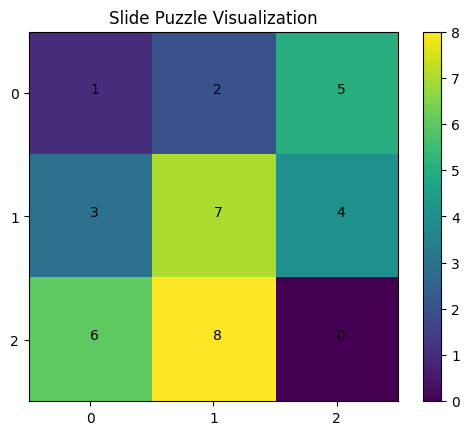

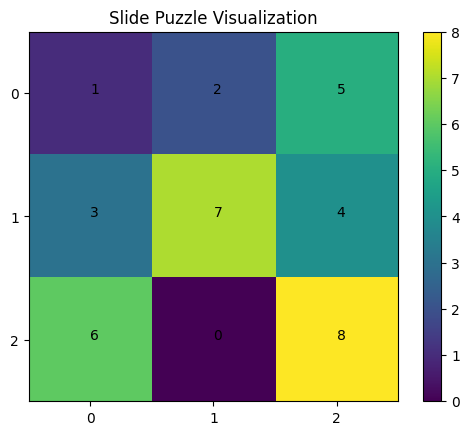

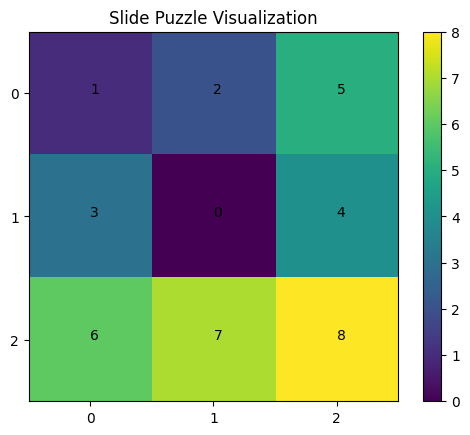

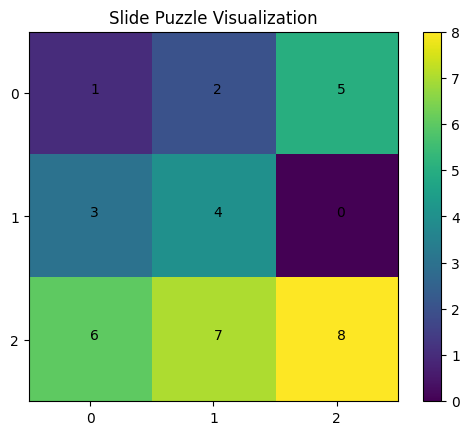

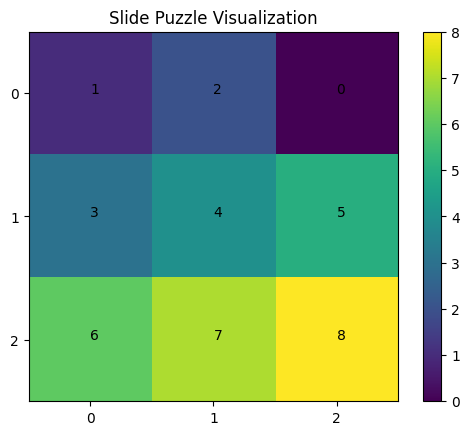

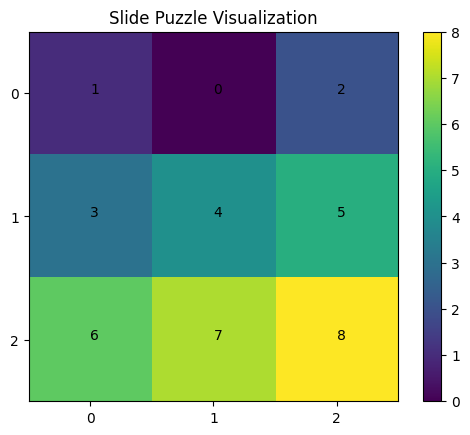

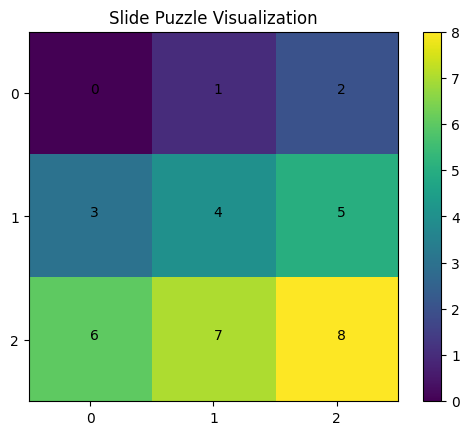

None
=== Running A* ===
SOLUTION FOUND!!
ACTION LIST: ['L', 'U', 'R', 'U', 'L', 'L']
SOLUTION COST: 6
EXPLORED NODE COUNT: 7
ELAPSED TIME: 0.0013797283172607422


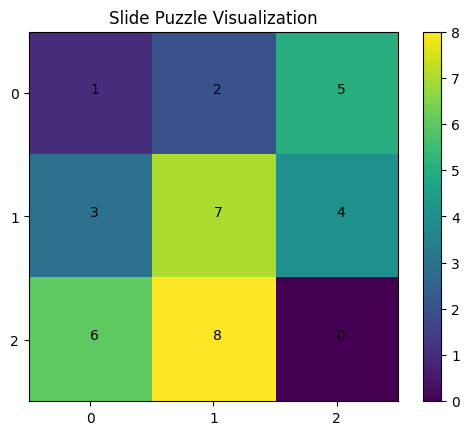

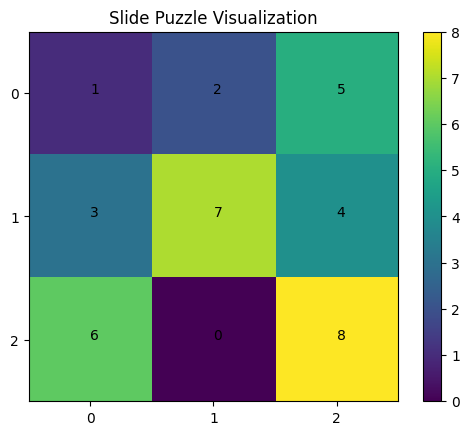

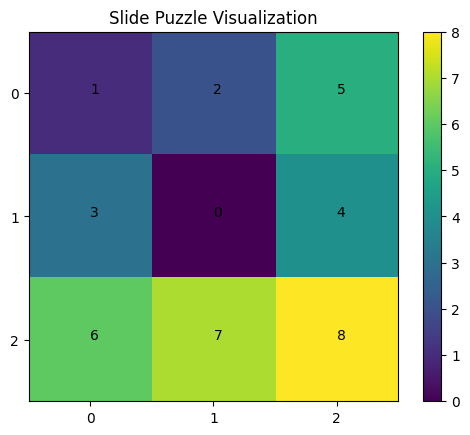

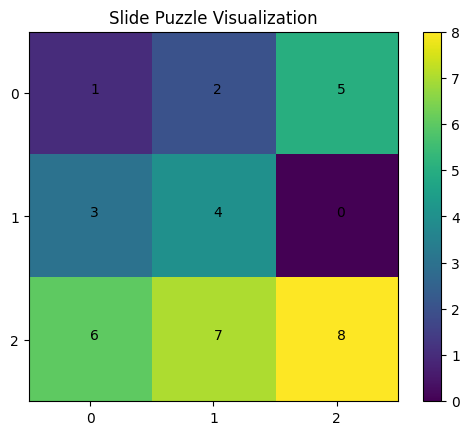

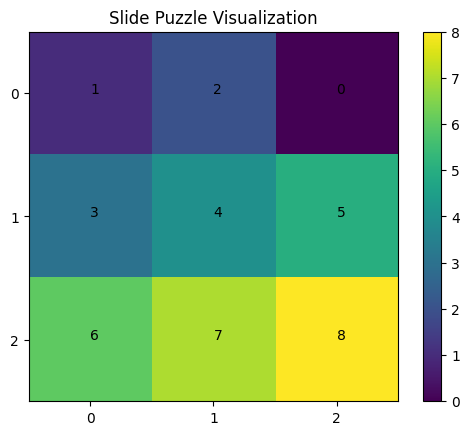

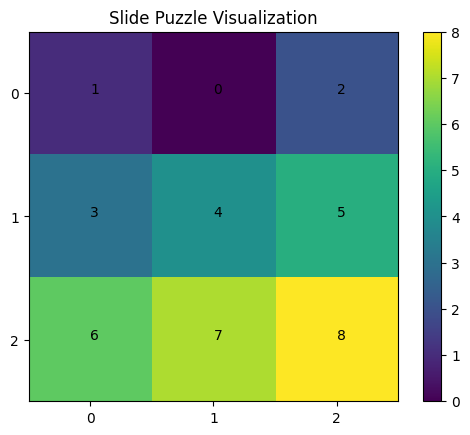

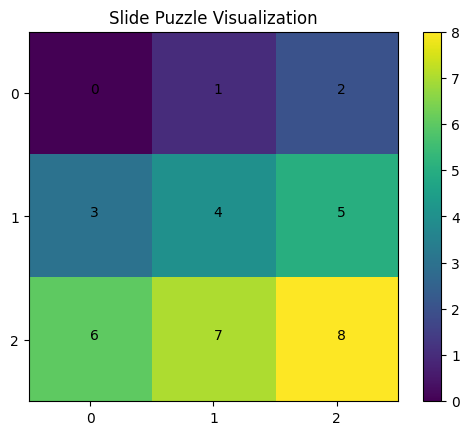

None


In [ ]:
if __name__ == '__main__':

    search = Searches()

    p = Problem()
    s = State()

    p.goalState = State(s)
    s.setBoard(((1,2,5),(3,7,4),(6,8,0)))

    # p.apply('R', s)
    # p.apply('R', s)
    # p.apply('D', s)
    # p.apply('D', s)
    # p.apply('L', s)

    p.initialState = State(s)
    print(p.initialState)

    print('=== Running BFS ===')
    res=search.BFS(p)
    print(res)
    # print("Explored Nodes: " + str(Node.nodeCount) + "\n")
    # Node.nodeCount = 0

    print('=== Running DFS ===')

    res = search.DFS(p)
    print(res)
    # print("Explored Nodes: " + str(Node.nodeCount) + "\n")
    # Node.nodeCount = 0

    print('=== Running Greedy ===')
    res = search.greedy(p)
    print(res)
    # print("Explored Nodes: " + str(Node.nodeCount) + "\n")
    # Node.nodeCount = 0

    print('=== Running A* ===')
    res = search.A_star(p)
    print(res)
    # print("Explored Nodes: " + str(Node.nodeCount) + "\n")
    # Node.nodeCount = 0

    # print("Generating Random Position\n")
    # si = State(s)
    # applyRndMoves(30,si,p)
    # p.initialState = si
    # print(si)

    # print('=== Running BFS ===')
    # res=search.BFS(p)
    # print(res)
    # # print("Explored Nodes: " + str(Node.nodeCount) + "\n")
    # # Node.nodeCount = 0

    # print('=== Runnning DFS ===')
    # res = search.DFS(p)
    # print(res)
    # # print("Explored Nodes: " + str(Node.nodeCount) + "\n")
    # # Node.nodeCount = 0

    # print('=== Running Greedy ===')
    # res = search.greedy(p)
    # print(res)
    # # print("Explored Nodes: " + str(Node.nodeCount) + "\n")
    # # Node.nodeCount = 0

    # print('=== Running A* ===')
    # res = search.A_star(p)
    # print(res)
    # # print("Explored Nodes: " + str(Node.nodeCount) + "\n")
    # # Node.nodeCount = 0
